# Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, f1_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pingouin import partial_corr

from collections import defaultdict
from itertools import product



/Applications/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
data = pd.read_csv('BTC-USD.csv').set_index("Date")
data.info()
data.head(3)


<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 2017-07-01 to 2022-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1734 non-null   float64
 1   High       1734 non-null   float64
 2   Low        1734 non-null   float64
 3   Close      1734 non-null   float64
 4   Adj Close  1734 non-null   float64
 5   Volume     1734 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.8+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-01,2492.600098,2515.270020,2419.229980,2434.550049,2434.550049,779913984
2017-07-02,2436.399902,2514.280029,2394.840088,2506.469971,2506.469971,803747008
2017-07-03,2498.560059,2595.000000,2480.469971,2564.060059,2564.060059,964112000


# Descriptive statistics:
The data consists prices and volumes for bitcoin from 2017-07-01 to 2022-03-30, consisting 1734 data points.
The data has no null values, the column "Close" and "Adj Close" are identical, so the column "Adj Close" is deleted.

In [3]:

data[data['Close'] - data['Adj Close'] > 0]
data.drop(columns = ['Adj Close'], inplace= True)


The basic statistics of the data:

In [4]:
data.describe().round(2)

,Open,High,Low,Close,Volume
count,1734.00,1734.00,1734.00,1734.00,1.734000e+03
mean,18265.60,18755.44,17728.73,18288.70,2.351330e+10
std,17606.22,18073.42,17070.37,17610.76,2.071565e+10
min,1932.62,2058.77,1843.03,1929.82,5.278560e+08
25%,6656.99,6793.96,6547.26,6673.96,6.258142e+09
50%,9375.00,9543.39,9232.01,9376.24,1.971738e+10
75%,32476.44,33754.28,31205.55,32553.80,3.423607e+10
max,67549.73,68789.62,66382.06,67566.83,3.509679e+11


The cross-correlation of the data:

In [5]:
data.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999347,0.998789,0.998395,0.610173
High,0.999347,1.000000,0.998694,0.999308,0.615406
Low,0.998789,0.998694,1.000000,0.999163,0.599089
Close,0.998395,0.999308,0.999163,1.000000,0.608617
Volume,0.610173,0.615406,0.599089,0.608617,1.000000


# Visualization of data

In [6]:

def trend_plot(data,name, special_dates = []):
    fig , ax = plt.subplots(figsize = (12,5))

    half_year_locator = mdates.MonthLocator(interval = 6)
    year_month_formatter = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.plot(pd.to_datetime(data.index), data, color = 'lightblue')
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_ylabel(name)
    ax.set_title('Trend of ' + name)
    if len(special_dates) > 0:
        spoints =[]
        for date in special_dates:
            spoints.append(data.loc[date])
        ax.scatter(pd.to_datetime(special_dates), spoints, color = 'red', s = 3,label = "special dates")
    ax.legend()
    plt.show()

<AxesSubplot:xlabel='Date'>

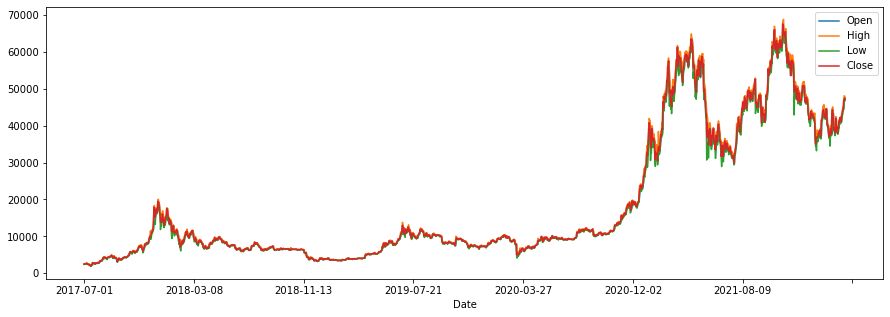

In [7]:
data[['Open', 'High', 'Low', 'Close']].plot(figsize =(15,5))

<AxesSubplot:xlabel='Date'>

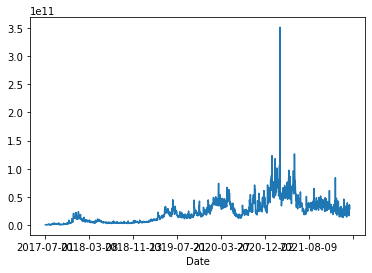

In [8]:
data['Volume'].plot()

<AxesSubplot:xlabel='Date'>

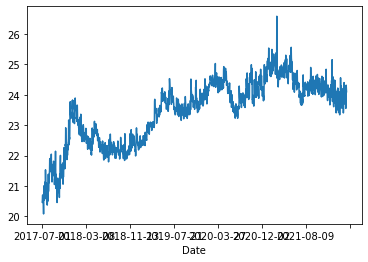

In [9]:
np.log(data['Volume']).plot()

Candlestick graph for close price:

In [10]:
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'])])
fig.show()

Close price after 2020/10:

<AxesSubplot:xlabel='Date'>

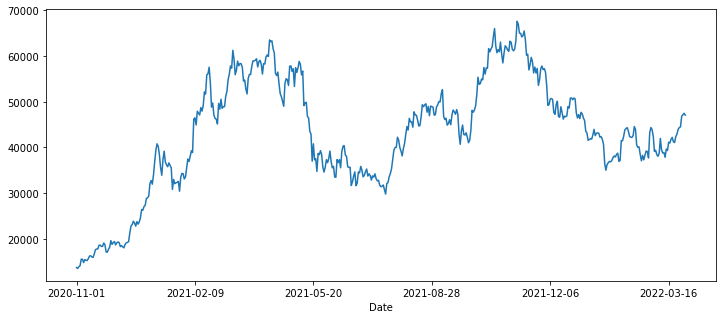

In [11]:
data.loc[pd.to_datetime(data.index) >= dt.datetime(2020,11,1), "Close"].plot(figsize = (12,5))

Description Summary:
The bitcoin close price was relatively stationary from 2017/07 to 2020/10. After a steady growth of one month, the close price of Bitcoin became non-stationary and has relatively dramatic price change. But overall the price has an increasing trend.

# Strategy:
The close price is not stationary. After differencing several time, it is still not stationary. Thus the ARIMA can not be applied directly to close price. Instead, we can use linear regression model to predict close prices for Bitcoin. 

By comparing predicted close price with today's close price, we will decide buying or selling the stock. 

We apply this strategy in a held-out set to compute returns. We will use average return and Sharpe ratio as model performance measures.

## Hold-out based validation:
We set apart the prices after 2021-06-30 as validation set, and used other data as training set. Compare the results of different model on validation set.

## Simple Linear Regression
$P_t$ denotes the close price at day $t$. 
Assume 
$$ P_t = X_t \beta  +  \epsilon$$
$X_t$ are features affecting $P_t$.

$\beta$ are unknown parameters, not depending on $t$. And $\epsilon$ is an error term not depending on $t$.

In [12]:

# This function gives the partial correlation of data[y] and data[x] shifted by lag with respect to other 
# variables data[x].shift(1), ..., data[x].shift(lag - 1)

def pcorr(x, y,lag, data = data):
    if lag == 1:
        return data[y].corr(data[x].shift(1))
    else:
        name = ['lag'+ str(i) for i in range(1,lag+1)]
        X = pd.DataFrame(columns= name  + [y])
        for i in range(1,lag + 1):
            X['lag'+str(i)] = data[x].shift(i)
            X[y] = data[y]
        
        X.dropna(inplace = True)
        return partial_corr(data = X, x = 'lag'+ str(lag), y = y, covar = name[:-1]).loc['pearson','r']

def pcorr_plot(x,y,lags, data= data):
    corrs = [0] * lags
    for lag in range(1,lags+1):
        # print(pcorr(x,y,lag, data))
        corrs[lag - 1] = pcorr(x,y,lag,data)
    
    plt.scatter(list(range(1,lags+1)), corrs)
    plt.title(f'Partial correlation with %s and %s with lags' %(x,y))
    plt.xlabel('lags')
    plt.ylabel('correlation')
    plt.show()
        

        



## Feature extraction 1:
* log volume of previous day, denoted as $LogVol_{t-1}$.
Because the volume is too large, thus we take the logarithm. 
We only take the previous day because the partial correlations with more shifts are small.

* previous day's close price, denoted as $P_{t-1}$.
We only take previous day because the pacf plots shown below.

The correlations between close price, volume and lagged log-volume are computed:                   Close  Log_Vol_lag1    Volume
Close         1.000000      0.604549  0.608617
Log_Vol_lag1  0.604549      1.000000  0.790447
Volume        0.608617      0.790447  1.000000


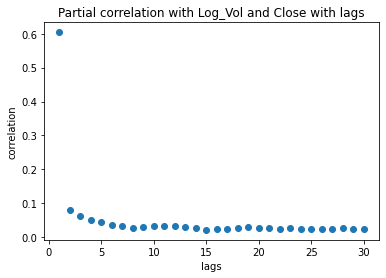

In [13]:
data['Log_Vol'] = np.log(data['Volume'])
data['Log_Vol_lag1'] = data['Log_Vol'].shift(1)

data['Close_lag1'] = data['Close'].shift(1)

print("The correlations between close price, volume and lagged log-volume are computed: ", data[['Close', 'Log_Vol_lag1', 'Volume']].corr())
pcorr_plot('Log_Vol', 'Close', lags = 30)

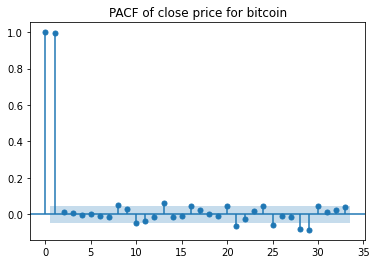

In [59]:
plot_pacf(data["Close"])
plt.title("PACF of close price for bitcoin")
plt.show()

In [14]:
pos_b = pd.to_datetime(data.index) < dt.datetime(2020,11,1)
pos_a = pd.to_datetime(data.index) >= dt.datetime(2020,11,1)

def features_display(fs, pos_b = pos_b, pos_a = pos_a, data = data):
    data[fs].plot(figsize = (12,5))
    plt.title('trends for features')
    plt.show()
    
    print('\n correlations between features with close price:\n ')
    print(data[fs + ['Close']].corr())

    print('\ncorrelations between features with close price AFTER 2020/11: ')
    print(data.loc[pd.to_datetime(data.index) >= dt.datetime(2020,11,1),fs + ['Close']].corr(),'\n')

    print('\ncorrelations between features with close price BEFORE 2021/11:')
    print(data.loc[pd.to_datetime(data.index) < dt.datetime(2020,11,1),fs + ['Close']].corr())

    
    
    


# Feature Extraction 2:
This set of features are related to the momentum of the close price.
* previous k- day momentum for Close price, i.e $P_{t-1} - P_{t-k}$, denoted by $r_k$.

* average previous k-day return i.e $\frac{1}{k-1}(P_{t - 1} - P_{t-k})/P_{t-k}$, denoted by $DReturn_k$.

Here, we choose $k$ to be $2,3,7,30,100$. 


In [15]:
# correlations between features
ks = [2,3,7,30,100]
rks = ['r'+str(k) for k in ks]
d_returns = ['DReturn' + str(k) for k in ks]
data['DReturn'] = (data['Close'] - data['Close'].shift(1) ).divide(data['Close'].shift(1))
for i in range(len(ks)):
    temp = data['Close'].shift(1) - data['Close'].shift(ks[i]) 
    data[rks[i]] = temp
    data[d_returns[i]] = temp.divide(data['Close'].shift(ks[i]))



## feature rk

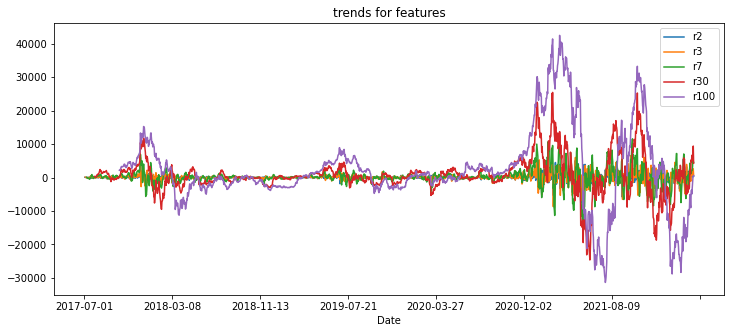


 correlations between features with close price:
 
             r2        r3        r7       r30      r100     Close
r2     1.000000  0.698896  0.422708  0.213065  0.091966  0.036854
r3     0.698896  1.000000  0.594659  0.293889  0.132111  0.052402
r7     0.422708  0.594659  1.000000  0.477948  0.242202  0.090844
r30    0.213065  0.293889  0.477948  1.000000  0.561715  0.184586
r100   0.091966  0.132111  0.242202  0.561715  1.000000  0.380753
Close  0.036854  0.052402  0.090844  0.184586  0.380753  1.000000

correlations between features with close price AFTER 2020/11: 
             r2        r3        r7       r30      r100     Close
r2     1.000000  0.697056  0.421432  0.214554  0.088217  0.027499
r3     0.697056  1.000000  0.595600  0.295363  0.127030  0.038870
r7     0.421432  0.595600  1.000000  0.476133  0.236067  0.076754
r30    0.214554  0.295363  0.476133  1.000000  0.556379  0.161468
r100   0.088217  0.127030  0.236067  0.556379  1.000000  0.451914
Close  0.027499  0.038870 

In [62]:
features_display(rks)

## feature Dreturnk

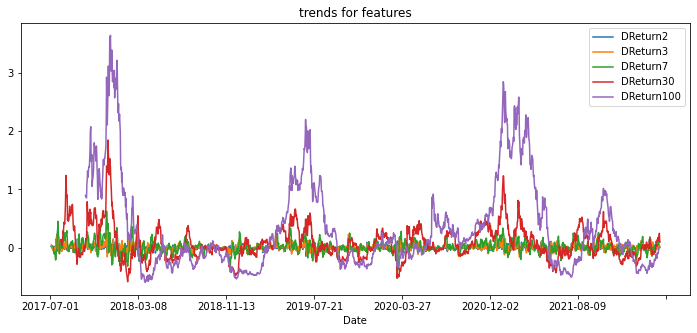


 correlations between features with close price:
 
            DReturn2  DReturn3  DReturn7  DReturn30  DReturn100     Close
DReturn2    1.000000  0.691083  0.416318   0.189241    0.111382  0.011437
DReturn3    0.691083  1.000000  0.589592   0.277348    0.164224  0.017042
DReturn7    0.416318  0.589592  1.000000   0.477983    0.284894  0.030290
DReturn30   0.189241  0.277348  0.477983   1.000000    0.640580  0.060024
DReturn100  0.111382  0.164224  0.284894   0.640580    1.000000  0.223634
Close       0.011437  0.017042  0.030290   0.060024    0.223634  1.000000

correlations between features with close price AFTER 2020/11: 
            DReturn2  DReturn3  DReturn7  DReturn30  DReturn100     Close
DReturn2    1.000000  0.693941  0.419506   0.204259    0.121267 -0.016146
DReturn3    0.693941  1.000000  0.600328   0.289024    0.177396 -0.024732
DReturn7    0.419506  0.600328  1.000000   0.476380    0.320218 -0.031853
DReturn30   0.204259  0.289024  0.476380   1.000000    0.657592 -0.096

In [63]:
features_display(d_returns)

# Feature Extraction 3:
The set of features show the price changes of bitcoin in certain periods.
* average of previous k-day difference between high and low prices, denoted by $d_k$.
$$d_k = \frac{1}{k}\sum_{i =1}^k  \text{High}_{t-i} - \text{Low}_{t-i}$$

* standard derivation of previous k - day close prices, denoted as $s_k$.

Here, $k$ is in $[2,3,7,30,100]$


In [16]:
ks = [2,3,7,30,100]
diff_names = ['d'+str(k) for k in ks]
sd_names = ['s' + str(k) for k in ks]

for i in range(len(ks)):
    X = (data['High'] - data['Low']).rolling(ks[i])
    data[diff_names[i]] =( X.mean()).shift(1)

    data[sd_names[i]] = (data['Close'].rolling(ks[i]).std()).shift(1)
    


## feature dk

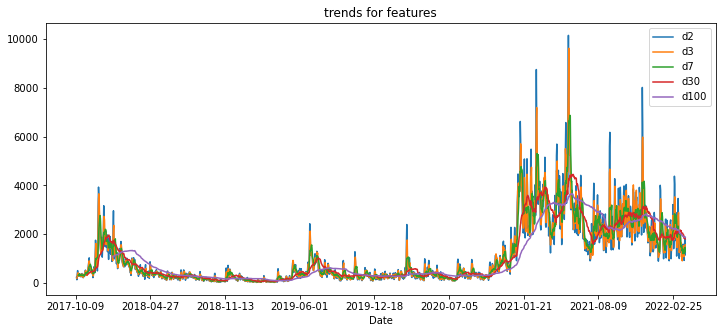


 correlations between features with close price:
 
             d2        d3        d7       d30      d100     Close
d2     1.000000  0.970684  0.924054  0.858403  0.794942  0.800323
d3     0.970684  1.000000  0.956450  0.887626  0.820975  0.824407
d7     0.924054  0.956450  1.000000  0.936136  0.863144  0.859128
d30    0.858403  0.887626  0.936136  1.000000  0.935825  0.900990
d100   0.794942  0.820975  0.863144  0.935825  1.000000  0.903055
Close  0.800323  0.824407  0.859128  0.900990  0.903055  1.000000

correlations between features with close price AFTER 2020/11: 
             d2        d3        d7       d30      d100     Close
d2     1.000000  0.919903  0.790493  0.584231  0.369407  0.371021
d3     0.919903  1.000000  0.870985  0.643871  0.408238  0.401496
d7     0.790493  0.870985  1.000000  0.769923  0.495070  0.453213
d30    0.584231  0.643871  0.769923  1.000000  0.739652  0.578926
d100   0.369407  0.408238  0.495070  0.739652  1.000000  0.602981
Close  0.371021  0.401496 

In [239]:
features_display(diff_names)

## feature sk

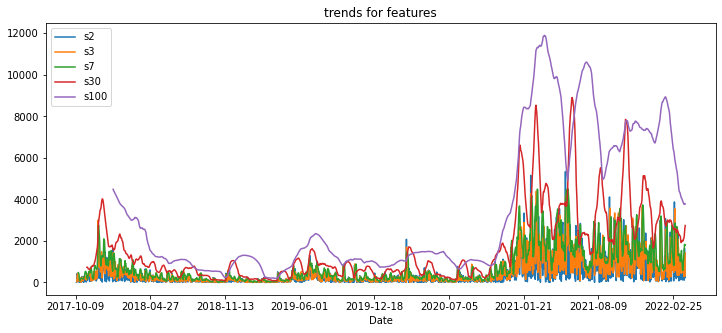


 correlations between features with close price:
 
             s2        s3        s7       s30      s100     Close
s2     1.000000  0.791992  0.615742  0.562381  0.567043  0.577061
s3     0.791992  1.000000  0.769890  0.667005  0.681369  0.693089
s7     0.615742  0.769890  1.000000  0.773717  0.782463  0.793633
s30    0.562381  0.667005  0.773717  1.000000  0.803471  0.798344
s100   0.567043  0.681369  0.782463  0.803471  1.000000  0.902435
Close  0.577061  0.693089  0.793633  0.798344  0.902435  1.000000

correlations between features with close price AFTER 2020/11: 
             s2        s3        s7       s30      s100     Close
s2     1.000000  0.663338  0.324607  0.226856  0.164103  0.212676
s3     0.663338  1.000000  0.510976  0.283289  0.222536  0.287589
s7     0.324607  0.510976  1.000000  0.399268  0.302430  0.380517
s30    0.226856  0.283289  0.399268  1.000000  0.341226  0.363082
s100   0.164103  0.222536  0.302430  0.341226  1.000000  0.548303
Close  0.212676  0.287589 

In [240]:
features_display(sd_names)

# Feature Extraction 4: Age
We have seen the price data is quite different before and after 2020/10. And the more close to predicted days, the more informative the data will be. 

So we consider a feature called Age, denoted as $\text{age}_k$. It is defined as the number of days between '2017-7-1'. We also consider some polynomial powers of this feature, and we would like to select a feature which is both related to Close price and can distinguish the price before and after 2020/10.

After exploration, feature age is taken.
 

In [17]:
data['age']=( pd.to_datetime(data.index) - dt.datetime(2017,7,1)).days

In [18]:
data['age2'] = data['age'] ** 2
data['age3'] = data['age'] ** 3
data['age4'] = data['age'] ** 4
age_names = ['age','age2','age3','age4',]

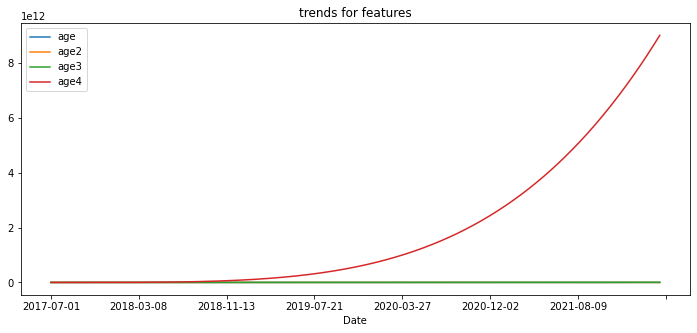


 correlations between features with close price:
 
            age      age2      age3      age4     Close
age    1.000000  0.968211  0.916456  0.865955  0.776072
age2   0.968211  1.000000  0.986009  0.958306  0.856185
age3   0.916456  0.986009  1.000000  0.992156  0.875979
age4   0.865955  0.958306  0.992156  1.000000  0.866903
Close  0.776072  0.856185  0.875979  0.866903  1.000000

correlations between features with close price AFTER 2020/11: 
            age      age2      age3      age4     Close
age    1.000000  0.998987  0.996011  0.991204  0.413517
age2   0.998987  1.000000  0.999016  0.996145  0.390106
age3   0.996011  0.999016  1.000000  0.999054  0.366779
age4   0.991204  0.996145  0.999054  1.000000  0.343739
Close  0.413517  0.390106  0.366779  0.343739  1.000000 


correlations between features with close price BEFORE 2021/11:
            age      age2      age3      age4     Close
age    1.000000  0.968196  0.916432  0.865926  0.331253
age2   0.968196  1.000000  0.98600

In [69]:
features_display(age_names)

# Baseline: Linear regression on all the features above.
The model is as follows:
$$ P_t = (\text(LogVol)_{t-1}, P_{t-1}, (r_k)_k, (Dreturn_k)_k (d_k)_k, (s_k)_k, age,1)\cdot \beta + e $$
here, the error term $e$ is a normal distribution independent of t. 
$k$ is in $[2,3,7,30,100]$
There are 21 features in total, and one constant.

In [19]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Vol', 'Log_Vol_lag1',
       'Close_lag1', 'DReturn', 'r2', 'DReturn2', 'r3', 'DReturn3', 'r7',
       'DReturn7', 'r30', 'DReturn30', 'r100', 'DReturn100', 'd2', 's2', 'd3',
       's3', 'd7', 's7', 'd30', 's30', 'd100', 's100', 'age', 'age2', 'age3',
       'age4'],
      dtype='object')

In [20]:

features = ['Log_Vol_lag1',
       'Close_lag1','r2', 'DReturn2', 'r3', 'DReturn3', 'r7',
       'DReturn7', 'r30', 'DReturn30', 'r100', 'DReturn100', 'd3', 's3', 'd7',
       's7', 'd30', 's30', 'd100', 's100', 'age','d2', 's2']
data.dropna(inplace = True)
data.head(3)


,Open,High,Low,Close,Volume,Log_Vol,Log_Vol_lag1,Close_lag1,DReturn,r2,...,d7,s7,d30,s30,d100,s100,age,age2,age3,age4
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-09,4614.520020,4878.709961,4564.250000,4772.020020,1968739968,21.400660,20.996243,4610.479980,0.035038,183.589843,...,148.700126,119.284887,250.210344,332.259328,231.996897,819.867687,100,10000,1000000,100000000
2017-10-10,4776.209961,4922.169922,4765.100098,4781.990234,1597139968,21.191480,21.400660,4772.020020,0.002089,161.540040,...,180.370117,189.739493,254.202010,357.284655,234.181096,820.934123,101,10201,1030301,104060401
2017-10-11,4789.250000,4873.729980,4751.629883,4826.479980,1222279936,20.923984,21.191480,4781.990234,0.009304,9.970214,...,178.011510,219.994903,249.624341,381.383104,234.557395,822.470803,102,10404,1061208,108243216


## Hold-out validation set:
Data after 2021-6-30 are taken as validation features.

In [21]:
train_ind = pd.to_datetime(data.index) <= dt.datetime(2021,6,30)
val_ind = pd.to_datetime(data.index) > dt.datetime(2021,6,30)
print('The size of validation set is %d, and the size of training set is %d' %( sum(val_ind),sum(train_ind)))

train_X = data.loc[train_ind,features]
train_Y = data.loc[train_ind, 'Close']

val_X = data.loc[val_ind,features]
val_Y = data.loc[val_ind,'Close']

The size of validation set is 273, and the size of training set is 1361


Here, we scale the features (using standard scaler) before feeding into the linear regression model. The prediction result will not change after scaling. Reason to scaling is that the computation of condition number depends on scaling, without scaling the condition number may be large, which may result in wrongly reporting strong collinearity.

In [22]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(train_X)
reg = sm.OLS(train_Y,sm.add_constant(scaled_X)).fit()
pred_Y = reg.predict(sm.add_constant(scaled_X))
resd =train_Y - pred_Y
reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.542e+04
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:39:01   Log-Likelihood:                -11082.
No. Observations:                1361   AIC:                         2.221e+04
Df Residuals:                    1337   BIC:                         2.234e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.373e+04     22.754    603.256      0.000    1.37e+04    1.38e+04
x1          -135.0648     57.797     -2.337      0.020    -248.447     -21.682
x2          1.296e+04    186.708     69.413      0.000    1.26e+04    1.33e+04
x3          -162.7174     47.180     -3.449      0.001    -255.273     -70.162
x4            69.9320     47.040      1.487      0.137     -22.349     162.213
x5            96.8220     55.092      1.757      0.079     -11.255     204.899
x6           -62.8546     53.665     -1.171      0.242    -168.132      42.422
x7            35.6156     49.626      0.718      0.473     -61.738     132.969
x8            28.8520     46.348      0.623      0.534     -62.071     119.775
x9          -397.2092     78.827     -5.039      0.000    -551.847    -242.571
x10          218.6172     57.165      3.824      0.000     106.474     330.760
x11          315.1000     86.120      3.659      0.000     146.154     484.046
x12         -137.9848     60.821     -2.269      0.023    -257.299     -18.670
x13            9.2791    158.100      0.059      0.953    -300.871     319.429
x14          103.9231     65.857      1.578      0.115     -25.271     233.117
x15          136.8168    124.298      1.101      0.271    -107.023     380.657
x16           30.4426     63.496      0.479      0.632     -94.120     155.005
x17         -295.3928    155.018     -1.906      0.057    -599.499       8.713
x18          -38.1001     61.761     -0.617      0.537    -159.259      83.059
x19         -317.2886    166.941     -1.901      0.058    -644.784      10.207
x20          935.2646    139.320      6.713      0.000     661.954    1208.575
x21          242.9522     73.713      3.296      0.001      98.346     387.559
x22         -214.1566    150.967     -1.419      0.156    -510.315      82.002
x23          121.8525     38.736      3.146      0.002      45.863     197.842
==============================================================================
Omnibus:                      300.362   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10514.380
Skew:                           0.182   Prob(JB):                         0.00
Kurtosis:                      16.612   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## statistic diagnostic plots for linear regression
* p-values: we can see that there are some features which has relative high p-values, which means the features maybe redundant.
* condition numbers are relatively large, which implies possibility of strong collinearity.
* residue plot


In [23]:
def residue_plot(resd):
       fig , ax = plt.subplots(figsize = (12,5))

       half_year_locator = mdates.MonthLocator(interval = 6)
       year_month_formatter = mdates.DateFormatter("%Y-%m")
       ax.xaxis.set_major_locator(half_year_locator)
       ax.xaxis.set_major_formatter(year_month_formatter)
       ax.scatter(pd.to_datetime(resd.index), resd)
       fig.autofmt_xdate()
       ax.set_xlabel('Date')
       ax.set_ylabel('Residues')
       ax.set_title('Residue plots')
       plt.show()


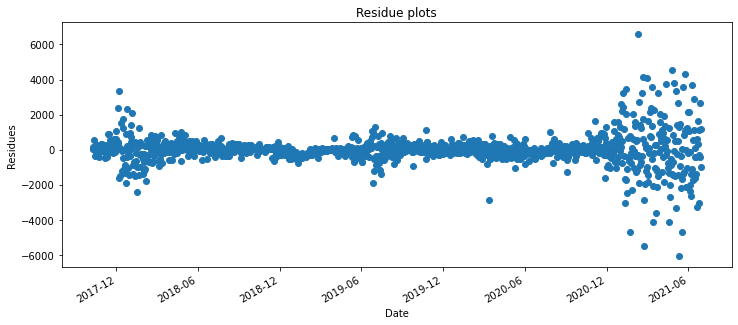

In [24]:
residue_plot(resd)


From the residue plots, the residue is not normal distribution with constant variance. Because the price trends are quite different before and after 2020/11, so we may trying to feed them with different features.


# Linear Regression: LASSO feature selections for different data
* LASSO:

We use feature $s_{30}$ to describe whether the price is "stationary" or not. For each group we conduct LASSO to select more outstanding features.

<!-- * Weighted Linear model:

From the plot above, the residue has different variances. So we can use weighted linear model assuming the error term having diagonal variance matrix instead of identity matrix.
 -->




Classify the data into stationary and non-stationary using $s30$. Threshold $1800$ seems a good classification. $s30$ is standard derivations for 30-day close prices.

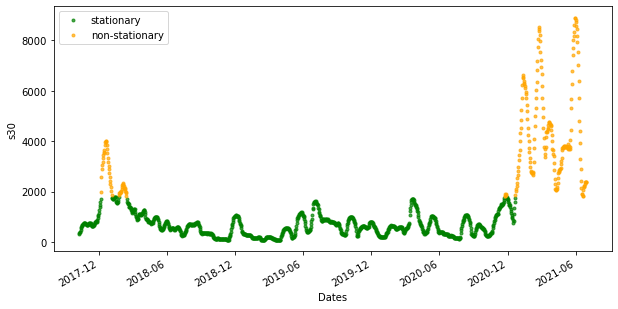

In [25]:
threshold = 1800
data1, Y1 = train_X.loc[train_X['s30'] < threshold], train_Y.loc[train_X['s30'] < threshold]
data2 , Y2 = train_X.drop(data1.index), train_Y.drop(Y1.index)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot_date(pd.to_datetime(data1.index), data1['s30'],xdate = True, color = 'green', alpha = 0.7, label = 'stationary',markersize = 3 )
ax.plot_date(pd.to_datetime(data2.index), data2['s30'],xdate = True, color = 'orange', alpha = 0.7, label= 'non-stationary', markersize = 3)
ax.legend()
ax.set_xlabel('Dates')
ax.set_ylabel('s30')
half_year_locator = mdates.MonthLocator(interval = 6)
year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
fig.autofmt_xdate()
plt.show()

Refine features using LASSO:

In [26]:
def features_selections(data, Y,features = features, alphas = [0.001,0.01,0.1,1,10,50,100,300,700,1000]):
    scaler = StandardScaler()
    std_X= scaler.fit_transform(data[features])
    # print(std_X[0])
    coefs = pd.DataFrame()
    coefs['Feature'] = features
    for alpha in alphas:
        lasso = Lasso(alpha = alpha, fit_intercept = True ,warm_start = True, max_iter = 5000)
        lasso.fit(std_X, Y)
        coefs['alpha = ' + str(alpha)] = lasso.coef_
    return coefs
    


We select the features which is large than 1 when the regularization $\alpha = 10$.

In [27]:
coef1 = features_selections(data1, Y1)
Xs = coef1.loc[np.abs(coef1['alpha = 10']) >= 5, 'Feature'].values
print('The more important features for stationary data are ')
print(Xs, '\n')
coef1

The more important features for stationary data are 
['Close_lag1' 'r30' 'r100' 'age'] 



,Feature,alpha = 0.001,alpha = 0.01,alpha = 0.1,alpha = 1,alpha = 10,alpha = 50,alpha = 100,alpha = 300,alpha = 700,alpha = 1000
0,Log_Vol_lag1,-56.964088,-56.961483,-56.880903,-57.098087,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Close_lag1,3128.442139,3128.403929,3128.095476,3123.820720,3131.767393,3107.24633,3057.24633,2857.24633,2457.24633,2157.24633
2,r2,67.283997,66.805700,62.039161,32.866265,-0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
3,DReturn2,-85.167870,-84.700756,-80.045997,-50.249278,-0.000000,-0.00000,0.00000,0.00000,0.00000,0.00000
4,r3,-12.996965,-12.578304,-8.391205,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
5,DReturn3,33.185184,32.775043,28.693032,18.246631,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
6,r7,-96.770520,-96.497599,-93.765482,-55.704298,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
7,DReturn7,96.969412,96.723477,94.233544,59.283645,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
8,r30,42.358237,42.142965,39.992377,19.754571,11.909205,0.00000,0.00000,0.00000,0.00000,0.00000
9,DReturn30,-37.461245,-37.188606,-34.496669,-7.544710,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000


We select the features which is large than 1 when the regularization $\alpha = 100$.

In [28]:
coef2 = features_selections(data2,Y2)
Xns = coef2.loc[np.abs(coef2['alpha = 100']) > 1, 'Feature'].values
print('The more important features for non-stationary data are ')
print(Xns, '\n')
coef2

The more important features for non-stationary data are 
['Log_Vol_lag1' 'Close_lag1' 'r2' 'DReturn7' 'r100' 's100' 'age' 's2'] 



,Feature,alpha = 0.001,alpha = 0.01,alpha = 0.1,alpha = 1,alpha = 10,alpha = 50,alpha = 100,alpha = 300,alpha = 700,alpha = 1000
0,Log_Vol_lag1,481.679631,481.580905,480.594386,470.778098,386.601744,151.543611,23.100709,135.604698,0.000000,0.0000
1,Close_lag1,11651.384705,11653.122000,11670.468410,11842.174135,13457.578236,14981.264812,15196.505060,15373.069346,15266.706024,15046.5972
2,r2,-574.411394,-574.191254,-571.989814,-549.972227,-324.075683,-146.126255,-66.177410,-0.000000,-0.000000,-0.0000
3,DReturn2,415.254901,414.990908,412.351070,385.958341,124.171818,-0.000000,-0.000000,-0.000000,-0.000000,-0.0000
4,r3,512.365385,512.124534,509.716103,485.637416,236.806796,0.000000,0.000000,0.000000,0.000000,0.0000
5,DReturn3,-468.433801,-468.150467,-465.317131,-436.983449,-153.463988,0.000000,0.000000,0.000000,0.000000,0.0000
6,r7,171.101971,170.980897,169.771609,157.774772,43.958300,0.000000,0.000000,0.000000,0.000000,0.0000
7,DReturn7,147.904964,147.914099,148.005184,148.898441,159.101319,131.351769,25.805899,0.000000,0.000000,0.0000
8,r30,-1367.581004,-1367.242202,-1363.855523,-1330.077802,-996.896458,-220.371429,-0.000000,0.000000,0.000000,0.0000
9,DReturn30,683.129932,682.919011,680.811301,659.833323,449.910402,-0.000000,-0.000000,-0.000000,-0.000000,-0.0000


## linear model (mixed and weighted version) mathematical description:
Recall, we group data satisfying $s30 <= 1800$  (resp. $ s30 > 1800$) as "stationary" (resp. "non-stationary"). 
We will divide features into three parts according to the correlation results above. 
* $X_c$ are the common informative features selected for both stationary and non-stationary data.
* $X_s$ (resp. $X_{ns}$) are the informative features selected only for stationary (resp. non-stationary) data. 

$$ P_s =( X_c , 1) * \beta + X_s * \gamma_s + e_s  \text{       for stationary data}$$
$$ P_{ns} = (X_c,1) * \beta + X_{ns} * \gamma_{ns} + e_{ns}  \text{       for non-stationary data}$$
Here, $\beta$ are fixed unknown parameters for both stationary and non-stationary data, the error terms are in different distribution for stationary and non-stationary data.
$$ e_s \sim N(0,\sqrt{ws} \text{Id}) $$
$$ e_{ns} \sim N(0,  \sqrt{wns} \text{Id}) $$
here $\frac{1}{ws}$ (resp. $\frac{1}{wns}$) is the weight for stationary data (resp. non-stationary) data.The weights are linear proportional to the inverse of data size.


Written in matrix form:
$$ P =  \begin{pmatrix}
        P_s\\
        P_{ns}
        \end{pmatrix} = \begin{pmatrix}
                            (X_c & 1) & X_s & 0 \\
                            (X_c &1 ) & 0 & X_{ns} 
                        \end{pmatrix} \begin{pmatrix}
                                        \beta \\
                                        \gamma_s\\
                                        \gamma_{ns}

                                        \end{pmatrix} + \begin{pmatrix} e_s \\ e_{ns} \end{pmatrix} $$  
                                        
So we can use this linear regression to solve for solutions.
In this case, there is no special features for stationary data. The matrix will be simpler.


## features

In [29]:
# only run once
Xc = set(Xs).intersection(Xns)
Xs = list(set(Xs) - Xc)
Xns = list(set(Xns) - Xc)
Xc = list(Xc)
print("The common features are ", Xc)
print("The unique features for stationary data are ", Xs)
print("The unique features for non-stationary data are ", Xns)


The common features are  ['age', 'Close_lag1', 'r100']
The unique features for stationary data are  ['r30']
The unique features for non-stationary data are  ['s2', 'DReturn7', 'r2', 's100', 'Log_Vol_lag1']


In [31]:
# be careful, do not change the order of the data
def modified_features(train_X,  threshold = threshold ): 
    X= pd.DataFrame()
    X[Xc] = train_X[Xc]
    X[Xs] = train_X[Xs]
    # X[['const_ns','const_s']]= 1
    X.loc[train_X['s30']> threshold, Xs] = 0
    X[Xns] = train_X[Xns]
    X.loc[train_X['s30'] <= threshold, Xns] = 0

    return X


## weights 
There are fewer non-stationary points than stationary ones. The weights are uniformly assigned in the group so that the total weights for different groups are the same. 

In [32]:
pos_ns = train_X['s30'] > threshold
pos_s = train_X['s30'] <=threshold

weights  = pd.DataFrame(index = train_X.index)
weights['weight'] = 1
# weights.loc[pos_s, 'weight'] = 1/ws
weights.loc[pos_ns, 'weight'] = pos_s.sum()/pos_ns.sum()


Similarly as before, we use standard scaling first. The prediction result will be the same. 
But here, to conveniently analyzing the residues, we scale the residue according to the weights.

In [33]:
X = modified_features(train_X)
w_scaler = StandardScaler()
scaled_X = pd.DataFrame(index = X.index)
scaled_X[X.columns] = w_scaler.fit_transform(X)
wt_reg = sm.WLS(train_Y,sm.add_constant(scaled_X),weights = weights).fit()
wt_pred_Y = wt_reg.predict(sm.add_constant(scaled_X))
wt_resd = train_Y - wt_pred_Y
wt_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.995
Model:                            WLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 3.023e+04
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:40:33   Log-Likelihood:                -11861.
No. Observations:                1361   AIC:                         2.374e+04
Df Residuals:                    1351   BIC:                         2.379e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.373e+04     42.629    321.983      0.000    1.36e+04    1.38e+04
age            183.0405     50.780      3.605      0.000      83.424     282.657
Close_lag1    1.284e+04     94.806    135.399      0.000    1.27e+04     1.3e+04
r100           139.7182     36.761      3.801      0.000      67.603     211.833
r30             34.0314     47.120      0.722      0.470     -58.406     126.468
s2             111.3194     30.887      3.604      0.000      50.728     171.911
DReturn7        76.7182     24.798      3.094      0.002      28.071     125.365
r2            -100.2244     23.353     -4.292      0.000    -146.037     -54.412
s100           570.7226    101.908      5.600      0.000     370.807     770.638
Log_Vol_lag1  -145.9970     68.230     -2.140      0.033    -279.845     -12.149
==============================================================================
Omnibus:                      352.060   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23693.920
Skew:                           0.049   Prob(JB):                         0.00
Kurtosis:                      23.440   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

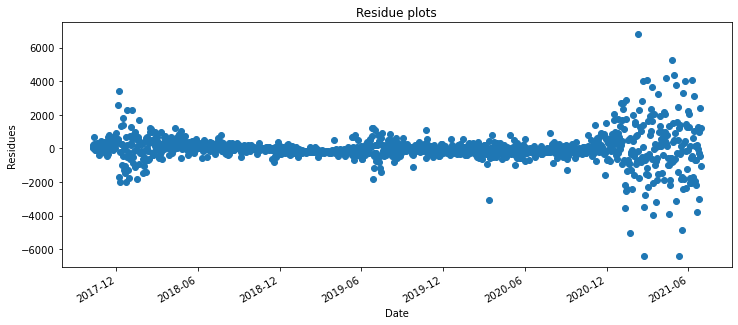

In [34]:
# mod_resd.loc[pos_ns] *= np.sqrt(ws/wns)
residue_plot(wt_resd)

# Classification Problem
We converted the problem into a classification problem. 
If today's close price $P_t$ is greater than previous close price $P_{t-1}$, then the data point is classifed as "increase".

The strategy will become if day t is forcasted as "increase", then at day t we will use one unit to buy the bitcoin. 
Similarly, we can have short version of the strategy but the weighted version does not work here. 

## Features
We will use the previous features.

In [71]:
clf_features = ['Log_Vol_lag1',
       'Close_lag1','r2', 'DReturn2', 'r3', 'DReturn3', 'r7',
       'DReturn7', 'r30', 'DReturn30', 'r100', 'DReturn100', 'd3', 's3', 'd7',
       's7', 'd30', 's30', 'd100', 's100', 'age','d2', 's2']

### method 1: two class classification problem.
If $P_t > P_{t-1}$, then day t is classified as "Increase", denoted as $1$, otherwise denoted as $0$.
I.e if $Dreturn > 0$, classified as 1; else 0.

In [36]:

data['Increase'] = 1* (data['Close'] > data['Close_lag1'])

data['Increase'].value_counts()
train_X = data.loc[train_ind]
val_X = data.loc[val_ind]

Description of DReturn:

<AxesSubplot:xlabel='Date'>

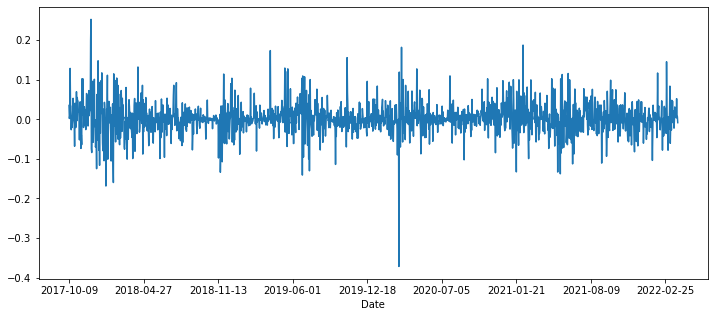

In [37]:
data['DReturn'].plot(figsize = (12,5))

<AxesSubplot:>

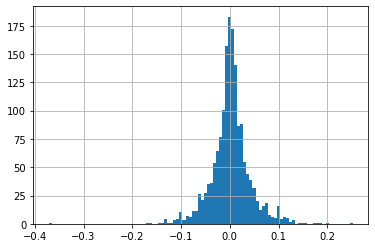

In [516]:
data['DReturn'].hist(bins = 100)

In [514]:
data['DReturn'].describe()

count    1632.000000
mean        0.002250
std         0.040987
min        -0.371695
25%        -0.015852
50%         0.001805
75%         0.019753
max         0.252472
Name: DReturn, dtype: float64

In [38]:
def hue_plot(data,col,classes,hue = 'Increase',colors = ['blue', 'red', 'green', 'yellow']):
    plt.figure(figsize = (6,6))
    for i, c in enumerate(classes):
        plt.hist(data.loc[data[hue] == c, col],bins = 100, color = colors[i], alpha = 0.5, label = 'Increase = ' + str(c))

    plt.title('Distribution for %s in different classes' %col)
    plt.legend()
    plt.show()

Plot the distribution of each feature for different group:

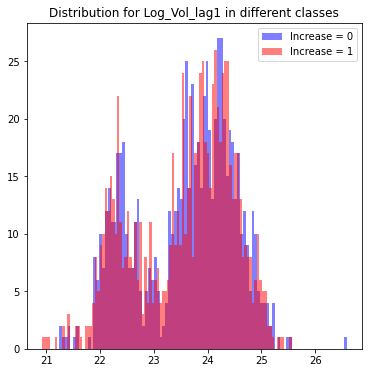

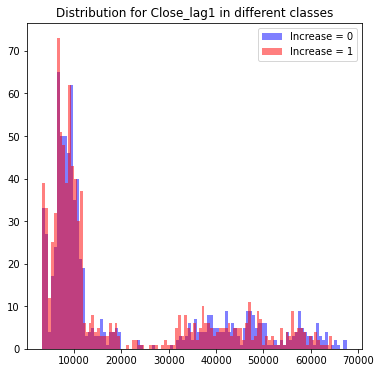

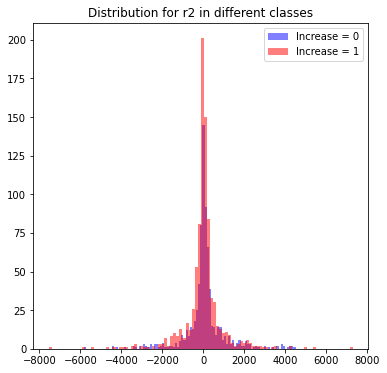

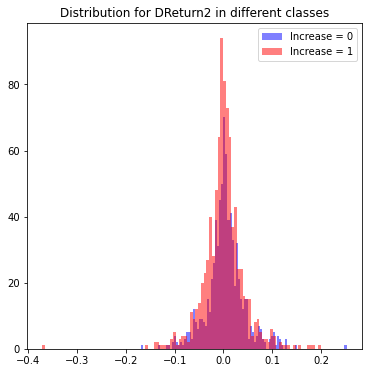

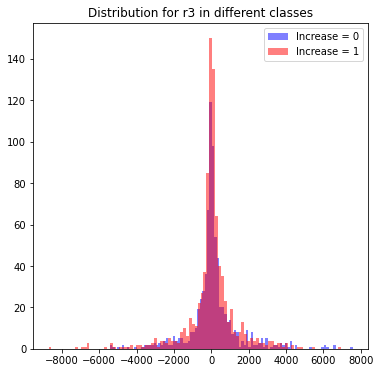

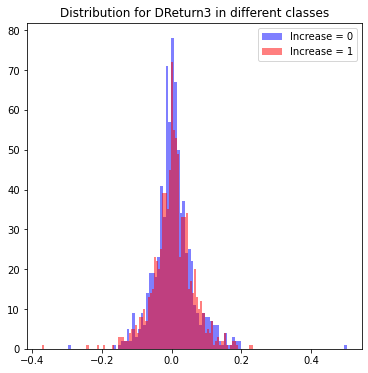

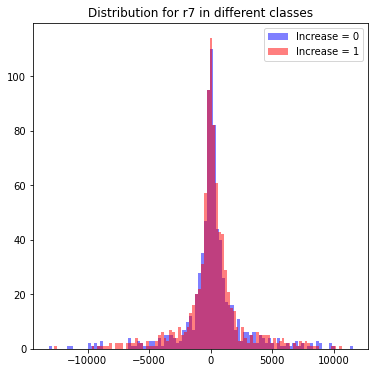

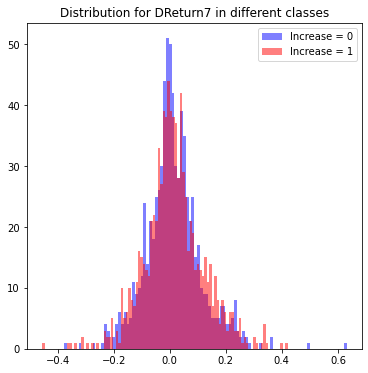

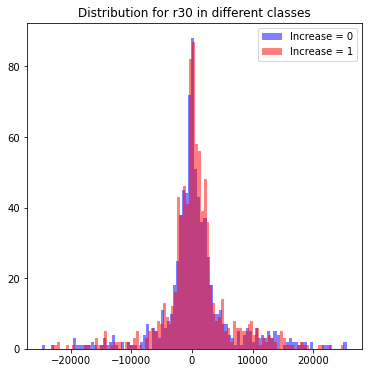

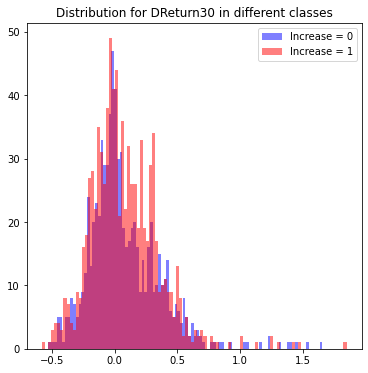

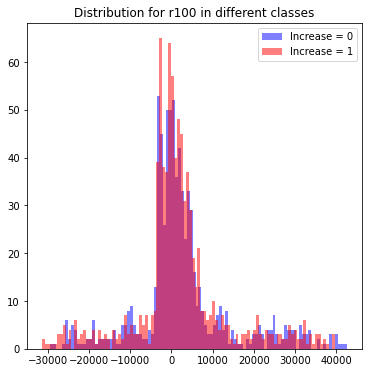

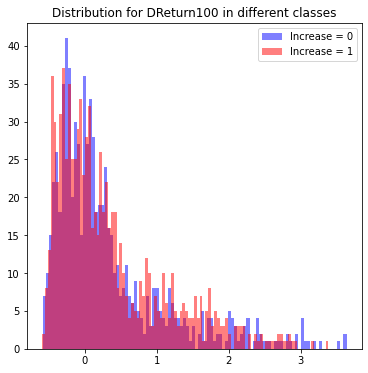

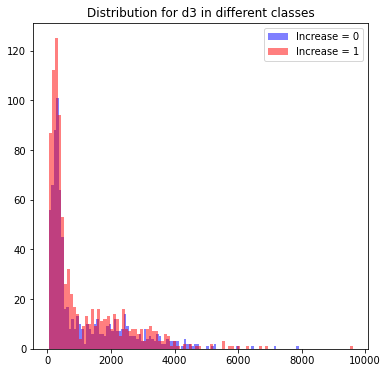

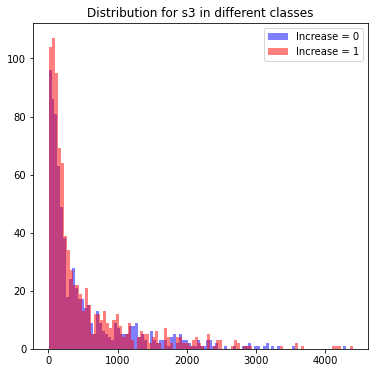

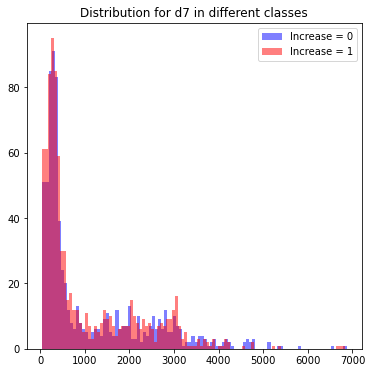

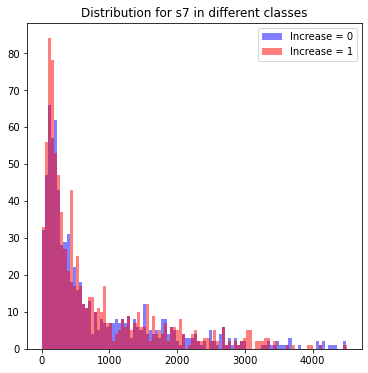

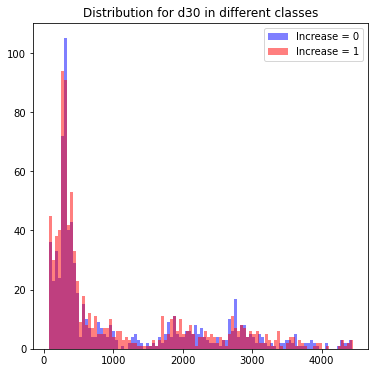

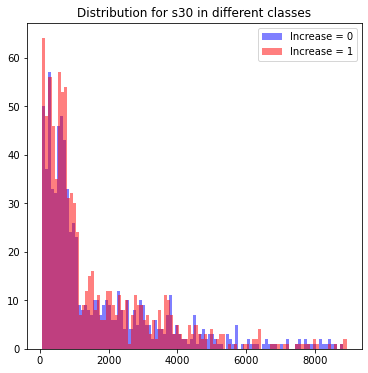

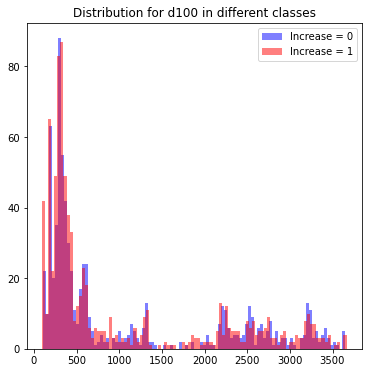

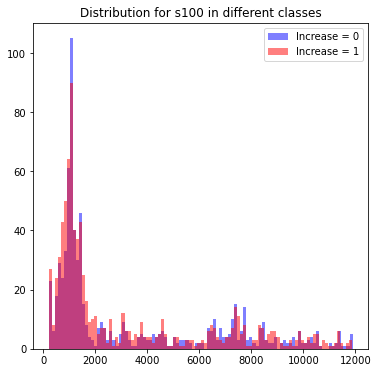

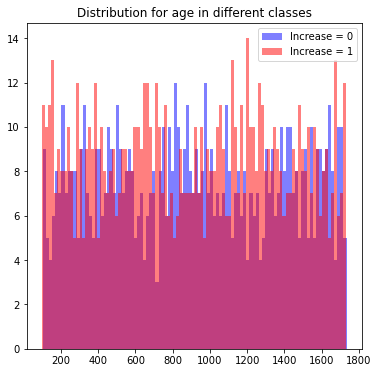

In [91]:

for x in clf_features:

   hue_plot(data,col = x, classes = [0,1])
   

From the distribution above, it is hard to distinguish 0 and 1 class. The logistic regression result below is not good. 

In [39]:
log_reg = LogisticRegression(penalty = 'none', max_iter = 5000)
log_reg.fit(train_X[clf_features], train_X['Increase'])
p = log_reg.predict(train_X[clf_features])
prob = log_reg.predict_proba(train_X[clf_features])

The confusion matrix is displayed below, and the classes label is [0,1]

In [40]:
confusion_matrix(train_X['Increase'], p)

array([[ 97, 537],
       [ 83, 644]])

Because most data are predicted as class 1, the threshold for class 1 maybe changed so that the f1 score can be improved. It turns out not. 

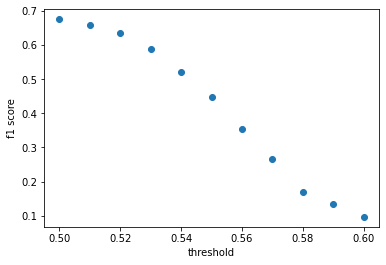

In [41]:

possible_Ts = [0.5 + 0.01* i for i in range(11)]
scores = [0] * len(possible_Ts)
for i,T in enumerate(possible_Ts):
    temp = 1 * (prob[:,1] > T)
    scores[i] = f1_score(train_X['Increase'], temp)
    # print(confusion_matrix(train_X['Increase'], temp))

plt.scatter(possible_Ts, scores)
plt.xlabel('threshold')
plt.ylabel('f1 score')
plt.show()

# Method 2: three classes classification problems
After playing around with features, we can divide daily return (DReturn) into three classes, the daily return with small changes, denoted as class 0; return which is relatively large positive, denoted as class 2, and relative dramatic negative return as class -2. 

More precise, we set parameters $t1$ and $t2$. If $ DReturn > t1$, it is class 2; if $ DReturn < t2 $, it is class -2; if $DReturn$ is between $t1$ and $t2$, it is class 0.

We conduct the three classes classification problems. 

How to find the proper threshold $t1, t2$?
We set up several measurements for the classification, then range over possible thresholds for division and pick the thresholds working best under these measurements.

In [42]:
def dreturn_category(threshold1, threshold2, data = data):
    data['Increase']  = 0
    data.loc[data['DReturn'] > threshold1,'Increase'] = 2
    data.loc[data['DReturn'] < threshold2, 'Increase'] = -2
    return data['Increase'].value_counts()


## Feature Selections:
We use l1 regularized logistic regression to select features.

This is a multi-class classification problem, I choose one-vs-rest to deduct it to a binary classification. 

For each class, we find several informative features to distinguish this class with others. The union of all these features will be used as final features.


We select the first 4 features with larger coefficients when the regularization C is proper.

In [72]:
#
def clf_feature_selections(data = data,num = 4, Cs = [50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001], classes = [-2,0,2],features = features):
    new_features = set()
    n = len(features)
    index = pd.MultiIndex.from_product([classes, Cs], names = ['Classes', 'Cs'])
    coefs = pd.DataFrame(index = index, columns = features)
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(data[features])
    threds = [0] * len(classes)
    for c in Cs:
        lasso_reg = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', multi_class = 'ovr')
        lasso_reg.fit(scaled_X, data['Increase'])
        for i, grp in enumerate(classes):
            coefs.loc[grp, c] = lasso_reg.coef_[i]
            if (threds[i] == 0) &( sum(coefs.loc[grp,c] == 0) > n/3) :
                threds[i] = c
    # print(threds)
    for i, grp in enumerate(classes):
        pos = coefs.loc[(grp,threds[i])]!= 0
        # print(np.abs(coefs.loc[(grp,threds[i]), pos]).sort_values( ascending = False).iloc[0:num].index)
        new_features = new_features.union(set(np.abs(coefs.loc[(grp,threds[i]), (coefs.loc[(grp,threds[i])]!= 0)]).sort_values( ascending = False).iloc[0:num].index))
        
    return new_features

    

## measurements for $t1,t2$:
We conduct logistic regression on previous selected features and get the predicted results. We use the following 5 measurements to test the prediction results.

* The correct prediction ratio,
* The least possible predicted class (using probability prediction result) is not the true class ratio, 
* The difference between predicted and true class is less or equal than 2 ratio, 
* true 2 class in predicted 2 class ratio
* true -2 class in predicted 0 class ratio
* true -2 class in predicted 2 class ratio

For the first 4 measurements, the larger the better; while for the last 2, the smaller the better.



In [73]:
def measurements(pred_df, classes):
    n = len(pred_df)
    correct_rate = sum(pred_df['pred'] == pred_df['Increase'])/n
    totoally_wrong_rate  = sum(pred_df['not_pred'] != pred_df['Increase'])/n
    semi_correct_rate = sum(np.abs(pred_df['pred'] - pred_df['Increase']) <= 2)/n

    ## not direct return the confusion matrix but the rate where true -2 class is classified as 0 or 2
    M = confusion_matrix(pred_df['Increase'], pred_df['pred'],labels = classes)
    inx  = classes.index(-2)
    inx0 = classes.index(0)
    inx2 = classes.index(2)

    # the next two ratios are true -2 classes in predicted 0 or 2 classes, we would like this to be smaller as possible
    rate_bin0 = M[inx,inx0]/sum(M[:,inx0])
    rate_bin2 = M[inx,inx2]/sum(M[:,inx2])
    # the last ratio are true 2 class in predicted 2, we would like this to be high as possible
    rate_gin2 = M[inx2,inx2]/sum(M[:,inx2]) 
    # index =pd.MultiIndex.from_product([['true'],classes])
    # temp = pd.DataFrame(confusion_matrix(pred_df['Increase'], pred_df['pred'], labels = classes), index = index, columns = classes)
   
    return [correct_rate, totoally_wrong_rate, semi_correct_rate,  rate_gin2,rate_bin0, rate_bin2]

In [94]:
## notice that this can only be run once, because product is an iter item
pos = pd.to_datetime(data.index) < dt.datetime(2021,7,1) 
def threshold_selections(threds, pos = pos, criterions = [0.4,0.75,0.8,0.4,0.25,0.35]):

    rates = defaultdict(list)
    for (t1, t2) in threds:
        dreturn_category(t1,t2)
        train = data.loc[pos]
        # print(train.loc[train['Increase'] == 0,'DReturn'].sum())
        avg =  train.loc[train['Increase'] == 0,'DReturn'].sum() 
        if avg < 0:
            continue
        
        nfeatures = clf_feature_selections()
    
        X = train[nfeatures]
        lreg = LogisticRegression(penalty = 'none',class_weight = 'balanced', max_iter = 5000, warm_start = True,multi_class = 'ovr')
        lreg.fit(X,train['Increase'])

        pred_df = pd.DataFrame(lreg.predict(X),index = train.index, columns = ['pred'])
        pred_df['Increase'] = train['Increase']
        pred_df['not_pred'] = [ lreg.classes_[i] for i in np.argmin(lreg.predict_proba(X),axis = 1)]

        A = measurements(pred_df, list(lreg.classes_))
        # if avg < 0:
        #     comp = criterions[3][0]
        # else:
        #     comp = criterions[3][1]
        res = [ True if A[i] >= criterions[i] else False for i in range(4)] + [True if A[i] <= criterions[i] else False for i in range(4,6)]
        # print(res)
        if all(res):
            rates[(t1,t2)] = (avg, A)
        #     # con_matrices.append(temp.copy())
            print((t1,t2))
    return rates

        

        

        

In [95]:
A = list(range(1,16,2))
T1 = [0.001 * a for a in A ]
T2 = [-0.001 * a for a in A]

threds = product(T1, T2)
rates = threshold_selections(threds)

(0.011, -0.011)
(0.013000000000000001, -0.013000000000000001)
(0.015, -0.013000000000000001)
(0.015, -0.015)


In [96]:
rates

defaultdict(list,
            {(0.011, -0.011): (0.1345962809775491,
              [0.44305657604702425,
               0.7795738427626745,
               0.8427626745040412,
               0.44106463878326996,
               0.24396442185514614,
               0.3269961977186312]),
             (0.013000000000000001,
              -0.013000000000000001): (0.27587034504848423, [0.46730345334313006,
               0.7759000734753857,
               0.8464364437913299,
               0.40892193308550184,
               0.20784313725490197,
               0.3308550185873606]),
             (0.015, -0.013000000000000001): (0.8033228849532561,
              [0.4893460690668626,
               0.7707567964731815,
               0.8530492285084497,
               0.4,
               0.20906801007556675,
               0.34509803921568627]),
             (0.015, -0.015): (0.4548149380731018,
              [0.49008082292432037,
               0.7795738427626745,
               0.858927259368111

In [97]:
# feed threhold into the model
def clf_model(t1,t2, pos = pos):
    
    dreturn_category(t1,t2)
    
    nfeatures = clf_feature_selections()
    train = data.loc[pos]
    X = train[nfeatures]
    lreg = LogisticRegression(penalty = 'none',class_weight = 'balanced', max_iter = 5000, warm_start = True,multi_class = 'ovr')
    lreg.fit(X,train['Increase'])

    pred_df = pd.DataFrame(lreg.predict(X),index = train.index, columns = ['pred'])
    pred_df['Increase'] = train['Increase']
    pred_df['not_pred'] = [lreg.classes_[i] for i in np.argmin(lreg.predict_proba(X),axis = 1)]

    return pred_df, lreg, nfeatures


In [100]:
pred_df, lreg, nfeatures = clf_model(0.015, -0.015)
# The confusion matrix is 
confusion_matrix(pred_df['Increase'], pred_df['pred'], labels = lreg.classes_)

array([[112, 158,  80],
       [ 92, 454,  66],
       [112, 186, 101]])

In [102]:
pred_df, lreg, nfeatures = clf_model(0.011, -0.011)
# The confusion matrix is 
confusion_matrix(pred_df['Increase'], pred_df['pred'], labels = lreg.classes_)

array([[122, 192,  86],
       [ 61, 365,  61],
       [128, 230, 116]])

We choose on threshold set $(t1,t2) = (0.011, -0.011)$ because of its relatively smaller portion of real -2 in predicted 0 and 2 classes.


## Reason not use ARIMA model on daily return

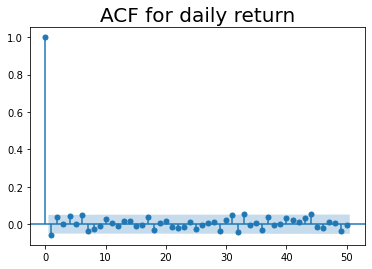

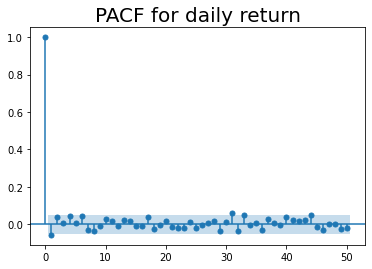

In [307]:
acf = plot_acf(data['DReturn'], lags=50, alpha=0.05)
plt.title("ACF for daily return", size=20)
plt.show()

pacf = plot_pacf(data['DReturn'], lags=50, alpha=0.05)
plt.title("PACF for daily return", size=20)
plt.show()

# Model performance:

We use daily return on the validation set to check the model performance. 

There are two main strategies for regression models: 
* long only
At the end of last day, we forecast next day's close price with the fitted models. If the forecast price is greater than the previous close, we buy 1 unit; otherwise, nothing will be done.

* both short and long
Instead of doing nothing when predicted price is smaller than previous close, we go short 1 unit. 

<!-- * weighted version of above strategy, if the difference between predicted price and last close price is large, then we buy or sell more, which is linear to the price difference (the ceiling). -->

The daily return for the second strategy is

if next day's predicted price > last day's close price:
$$ \frac{\text{next day's real price } - \text{last day's price}}{\text{last day's price}} $$ 
if next day's predicted price < last day's close price:
$$ \frac{\text{last day's price } - \text{next day's real price}}{\text{last day's price}} $$ 

For classification model, if the forcast DReturn is class 2, then we buy. We also have short and long version, if the forcast DReturn is in class 0 or 2, then we sell. Because the average return for class 0 is negative. 

## return measure
* The average daily return.

* The Sharpe ratio:

Assume the risk free rate is $0$:
$$ SR = \frac{E[R_p]}{\sigma (R_p)} $$
Here $R_p$ is the daily return rate computed as above.

The larger Sharpe ratio is the better the model performance is.






# In-sample v.s out-sample

We first apply different strategies on the train samples. Check how the strategies work. Then we pick the strategy works best with our model and compute the returns on the validation sets.


In [103]:
pos_b = pd.to_datetime(train_X.index)  <= dt.datetime(2020, 11,1)
pos_a = pd.to_datetime(train_X.index) > dt.datetime(2020,11,1)

# def daily_return(pred_close, close,model, method = 'L', weight = 'non_weighted'):

#     dr = pd.DataFrame()
#     if model == 'Baseline':
#         return (close - close.shift(1)).divide(close.shift(1)) 
#     if (model == 'SLR') or (model == 'WLR'):
#         dr = (pred_close > close.shift(1)) * 1  * (close - close.shift(1)).divide(close.shift(1)) 
        
#         if method == 'SL':
#             dr += ((pred_close < close.shift(1)) * 1  * (close.shift(1) - close)).divide(close.shift(1)) 
#         if weight == 'weighted':
#             dr = dr *np.ceil( np.abs(pred_close - close.shift(1)))
#     elif model == 'LogR':
#             dr = (pred_close == 2 ) * (close - close.shift(1)).divide(close.shift(1)) 
#             if method == 'SL' :
#                 dr += (pred_close != -2 ) * (close - close.shift(1)).divide(close.shift(1)) 


## two methods with "L" and 'SL'
def daily_return(pred_close, close,model, method = 'L'):
    dr = pd.DataFrame()
    if model == 'Baseline':
        return (close - close.shift(1)).divide(close.shift(1)) 
    if (model == 'SLR') or (model == 'WLR'):
        dr = (pred_close > close.shift(1)) * 1  * (close - close.shift(1)).divide(close.shift(1)) 
        
        if method == 'SL':
            dr += ((pred_close < close.shift(1)) * 1  * (close.shift(1) - close)).divide(close.shift(1)) 
        # if weight == 'weighted':
        #     dr = dr *np.ceil( np.abs(pred_close - close.shift(1)))
    elif model == 'LogR':
            dr = (pred_close != -2 ) * (close - close.shift(1)).divide(close.shift(1)) 
            if method == 'SL' :
                dr += (pred_close == -2 ) * (close.shift(1)- close).divide(close.shift(1)) 


        # dr = (pred_close != 2 ) * (close - close.shift(1)).divide(close.shift(1)) 

        # if method == 'SL':
        #     dr += (pred_close == -2 ) * (close.shift(1)-close).divide(close.shift(1)) 
    return dr
def avg_dayreturn(daily_return, days):
    if days == 'all':
        return daily_return.mean()
    elif days == 'old':
        return daily_return.loc[pos_b].mean()
    elif days == 'new':
        return daily_return.loc[pos_a].mean()


def Sharpe(daily_return, days):
    # print('The average daily return is ',daily_return.mean())
    # SR = daily_return.mean()/ daily_return.std()
    # print('The Sharpe Ratio is ', SR)
    if days == 'all':
        return daily_return.mean()/ daily_return.std()
    elif days == 'old':
        return (daily_return.loc[pos_b]).mean()/ (daily_return.loc[pos_b]).std()
    elif days == 'new':
        return (daily_return.loc[pos_a]).mean()/ (daily_return.loc[pos_a]).std()
    
    
def day_return_plot(daily_return, data , method, weight , model):
    daily_return.plot(figsize =( 12,5))
    plt.title(' %s daily return of model %s with method %s for %s data' % ( weight, model, method, data ))
    plt.xlabel('date')
    plt.ylabel('daily return')
    plt.show()
    
    

    

def pred_plot(pred_close, close):

   
    fig = plt.figure(figsize= (12,5))
    ax = fig.add_subplot()
    ax.plot(pd.to_datetime(pred_close.index), pred_close, color = 'lightblue', label = 'Predicted')

    ax.plot(pd.to_datetime(pred_close.index), close, color = 'orange', label = 'Actual')
    ax.legend()
    ax.set_title('predicted vs actual close price')
    ax.set_xlabel('dates')
    ax.set_ylabel('close price')

    one_month_locator = mdates.MonthLocator(interval = 1)
    year_month_formatter = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_locator(one_month_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    fig.autofmt_xdate()
    plt.show()



In [53]:
layers =[['train','val'],['L','SL'],['all','old','new'],['average_DReturn', 'Sharpe']]
index = pd.MultiIndex.from_product(layers, names=["Id1", "Id2",'Id3','Id4'])
model_names = ['Baseline','SLR', 'WLR', 'LogR']

performances = pd.DataFrame(index = index,columns = model_names)
performances = performances.sort_index()


In [104]:
train_predY = pd.DataFrame(index = train_X.index, columns = model_names[1:])
train_predY = [pred_Y, wt_pred_Y, pred_df['pred']]
val_predY = []
val_predY.append( reg.predict(sm.add_constant(scaler.transform(val_X[features]))) )
val_predY.append( wt_reg.predict(sm.add_constant(w_scaler.transform(modified_features(val_X)))) )
val_predY.append(lreg.predict(val_X[nfeatures]))
list1 = [train_predY,val_predY]
list2 = [train_Y, val_Y]

In [105]:
for i, s in enumerate(['train','val']):
        for  k, m in enumerate(model_names):
            if m == 'Baseline':
                temp = daily_return(list2[i],list2[i], model = m)
                
                for d in ['all', 'old','new']:
                    if( d !='all') and s == 'val': 
                        continue
                    performances.loc[(s, 'SL',d,'average_DReturn'), 'Baseline' ] = avg_dayreturn(temp,d)
                    performances.loc[(s, 'SL',d,'Sharpe'), 'Baseline' ] = Sharpe(temp,d)  
                        
            else:
                for method in ['L','SL']:
                    # if m == 'LogR':
                        temp = daily_return(list1[i][k-1],list2[i],model = m, method = method)
                        # if d == 'all':
                        #     day_return_plot(temp,s, method,'non_weighted', m)
                        for d in ['all', 'old','new']:
                            if( d !='all') and s == 'val': 
                                continue
                            performances.loc[(s,d, method,'average_DReturn'), m ] = avg_dayreturn(temp,d)
                            performances.loc[(s,d, method, 'Sharpe'), m ] = Sharpe(temp,d)
                    # else:
                    #     # for w in ['weighted', 'non_weighted']:
                    #     temp = daily_return(list1[i][k-1],list2[i],model = m, method = method)
                        
                    #     # if d == 'all':
                    #     #     day_return_plot(temp,s, method,w, m)
                    #     for d in ['all', 'old','new']:
                    #         if( d !='all') and s == 'val': 
                    #             continue
                    #         performances.loc[(s,d, method,'average_DReturn'), m ] = avg_dayreturn(temp,d)
                    #         performances.loc[(s,d, method,'Sharpe'), m ] = Sharpe(temp,d)
                    
                            
            
                        


/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Applicati

In [106]:
train_per = performances.xs('train', level = 'Id1')
val_per = performances.xs('val',level = 'Id1')

# performance on Train set:

In [57]:
train_per['Baseline'].dropna()

Id2  Id3  Id4            
SL   all  Sharpe             0.056101
          average_DReturn    0.002367
     new  Sharpe             0.107119
          average_DReturn    0.004954
     old  Sharpe             0.043859
          average_DReturn     0.00181
Name: Baseline, dtype: object

In [107]:
train_per[['SLR',"WLR", "LogR"]].dropna()

SLR       WLR      LogR
Id2 Id3 Id4                                          
all L   average_DReturn  0.003551    0.0024  0.001921
        Sharpe           0.111182  0.073026  0.055629
old L   average_DReturn  0.002881  0.001534  0.000993
        Sharpe           0.091741  0.047234  0.028614
new L   average_DReturn  0.006663  0.006421  0.006229
        Sharpe           0.194701  0.186633  0.186443
all SL  average_DReturn  0.004734  0.002432  0.001475
        Sharpe           0.112731  0.057646  0.034929
old SL  average_DReturn  0.003951  0.001257  0.000177
        Sharpe           0.096075  0.030446  0.004279
new SL  average_DReturn  0.008371  0.007888  0.007504
        Sharpe           0.182989  0.172095  0.163502

# Summary:
As we can see, both the weighted linear regression model and logistic regression model will perform better in newer data.
The weighted linear regression model and logistic regression model both work better for the short and long strategy.

So we will choose to use the short and long strategy on the validation data set. 


## Performance on validation set:

The baseline model performance is listed below:

In [108]:
val_per['Baseline'].dropna()

Id2  Id3  Id4            
SL   all  Sharpe             0.053269
          average_DReturn    0.001826
Name: Baseline, dtype: object

The model performances for linear regression models and logistic regression classification model: 

In [109]:
val_per[['SLR',"WLR", "LogR"]].dropna()


SLR       WLR      LogR
Id2 Id3 Id4                                          
all L   average_DReturn  0.000163 -0.000676  0.001073
        Sharpe           0.008081 -0.097093  0.039293
    SL  average_DReturn   -0.0015 -0.003177  0.000319
        Sharpe          -0.043746 -0.092961  0.009309